# Morris Sensitivity Analysis (Elementary Effects Method)

In global sensitivity analysis, the **Morris Method** (also called the *Method of Elementary Effects*) is a screening technique used to identify which input variables in a model have the greatest influence on the output. It was introduced by Max D. Morris in 1991 as a computationally efficient way to explore sensitivity in models with many inputs, without requiring an enormous number of model runs.

The basic idea is:

- Change one input at a time by a small step,
- See how much the output changes,
- Repeat this from different starting points across the input space,
- Summarize how consistently (or inconsistently) each input causes change.

That small one-at-a-time change in an input and the resulting change in the model output is called an **elementary effect**.

---

## Why was Morris developed?

Before Morris (1991), sensitivity analysis often lived in two extremes:

- **Local / derivative-based sensitivity**:  

  This asks “If I make a tiny change to one parameter around the current baseline, how much does the output change?”  
  *This is basically a partial derivative.*  

  **Problem:** it only tells you about behavior *near one point* in parameter space, and it assumes smooth / linear behavior.

- **Full global variance-based methods (like Sobol indices)**:  

  These methods try to quantify how much of the total output variance is explained by each input and by their interactions.
    
  They’re extremely informative — but also computationally expensive, because they require a lot of model evaluations.

Max Morris was looking for something in-between:

- A method that is **global** (explores the whole parameter space, not just one point),
- But still **cheap enough** to run early, even for high-dimensional problems (many inputs),
- And able to flag inputs that are likely important, nonlinear, or interacting.

So the Morris method is often described as a **screening method**: it’s a first pass that tells you which inputs matter and how they matter, so you know where to focus more detailed analysis later.

---

## What problems does the Morris method solve?

Imagine you have a model:

$$
y = f(x_1, x_2, x_3, \dots, x_k)
$$

where each $x_i$ is an input (a criterion weight, a threshold, a soil parameter, etc.), and $y$ is some decision score (e.g. total suitability, predicted recharge, contaminant load, habitat score).

You want to know:

1. Which inputs have basically **no effect** on $y$? (Those might be safely fixed or ignored.)
2. Which inputs have a **large overall effect** on $y$? (These are important drivers.)
3. Which inputs behave **nonlinearly** or **interact** with other inputs?  
   (For example, “slope only matters once soil permeability is high,” or “forest cover and precipitation together change infiltration potential in a way you don’t get by looking at either alone.”)

The Morris method gives you exactly that information with two summary statistics per input.

---

## Core concept: the Elementary Effect

For each input $x_i$, we define an *elementary effect* as:

$$
EE_i = \frac{f(x_1, \dots, x_i + \Delta, \dots, x_k) - f(x_1, \dots, x_i, \dots, x_k)}{\Delta}
$$

Where:

- $\Delta$ is a small step in the value of $x_i$,
- All other inputs are held constant for that step,
- The numerator is “how much the output changed when we nudged just $x_i$.”

Interpretation:

- $EE_i$ is basically: “If I change only $x_i$ a little, how much does the model output respond?”

But — and this is the key difference from local sensitivity — we don’t do this just once from one baseline. We repeat this from *multiple random locations* in the input space. Each repetition gives us another possible elementary effect for that same input.

So for each input $x_i$, we don’t just get one number. We get a distribution of elementary effects across the space of plausible inputs.

---

## Morris summary metrics

After computing many elementary effects for each input, we summarize them. The two most common summaries are:

1. **$\mu^*$** (mu star):  

   The mean of the *absolute value* of the elementary effects for that input.  
   - High $\mu^*$ means: changing this input tends to cause a big change in the output overall.  
   - This is interpreted as “overall importance” or “influence strength.”

   We use the absolute value so positive and negative effects don’t cancel each other out.

2. **$\sigma$** (sigma):  

   The standard deviation of the elementary effects for that input.  
   - High $\sigma$ means: the effect of this input is not consistent — sometimes it has a big effect, sometimes small, sometimes positive, sometimes negative.  
   - That usually indicates **nonlinearity** or **interactions with other inputs**.

   Intuition: if an input only mattered under certain combinations of other inputs, you’d see a wide spread in its elementary effects → high σ.

This gives you a beautiful diagnostic plot: μ\* on the x-axis (importance) vs σ on the y-axis (interaction / nonlinearity).

- Inputs with **low μ\*** and **low σ** → mostly irrelevant.
- Inputs with **high μ\*** and **low σ** → consistently important, mostly linear effect on the output.
- Inputs with **high μ\*** and **high σ** → important but tricky: nonlinear or involved in interactions.

That’s the classic “Morris scatter plot.”

---

## How it works (conceptually)

1. Define ranges (or distributions) for each input $x_i$.  
   Example: slope weight in WLC could vary from 0.1 to 0.4, precipitation weight from 0.2 to 0.6, etc.

2. Sample a sequence of points in that input space (called “trajectories” or “paths”).  
   Each path walks through the space one input at a time, changing one variable by $\Delta$ while keeping the others fixed, then moving on to the next variable, etc.

3. For each step along that path, compute the elementary effect $EE_i$.

4. Aggregate all the elementary effects for each input across all paths → get $μ^*$ and $\sigma$.

5. Rank or plot inputs based on $\mu^*$ and σ to decide which inputs matter.

This is global because you’re sampling across the full allowable range of inputs — not just perturbing around a single baseline point.

---

## Why this is used

The Morris method is widely used in:

- Environmental modeling and hydrology (e.g., identifying which hydrogeologic parameters most influence recharge estimates or contaminant transport),
- Ecological and habitat suitability modeling,
- Groundwater recharge / infiltration models,
- Flood and erosion models,
- Multi-criteria decision analysis (MCDA), including GIS-based suitability mapping, to see which criteria weights dominate the final suitability score, and where there are strong interactions.

In practice:

- You run Morris first to screen out unimportant variables (so you don’t waste computation on them),
- Then you apply heavier methods (like Sobol variance decomposition) on the variables that survived screening.

So Morris is both:

1. A science tool (which parameters actually matter?),
2. A workflow tool (where should I spend my expensive computation time?).

---

## Summary

- The Morris method is a global, one-factor-at-a-time sensitivity screening method introduced by Max D. Morris in 1991.
- It’s built around **elementary effects**: the change in model output when you nudge one input while holding others constant.
- By repeating that across many starting points, you get a *distribution* of effects for each input.
- You then summarize each input with:
  - **$\mu^*$** (mean absolute elementary effect): how influential this input is overall,
  - **$\sigma$** (stdev of elementary effects): how nonlinear or interaction-heavy its influence is.
- This is incredibly helpful in decision-support models (like WLC suitability mapping) because it tells you:
  - which criteria weights dominate suitability,
  - which ones only matter in combination,
  - and which ones are basically irrelevant.

---

Next, we’ll:

1. Build a tiny synthetic model in Python so you can *see* elementary effects for a toy function,
2. Compute $\mu^*$ and $\sigma$ for each input manually,
3. Reproduce what SALib’s `morris` routines do,
4. Visualize $\mu^*$ vs $\sigma$,
5. Then connect that to a spatial WLC / MCDA setting.

> Now let’s start generating elementary effects for a simple model in Python.

In [1]:
## Import libraries and set random seed for repeatability 

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt 


np.random.seed(12)

1. Lets define a sample model

We want the model to have the following attributes:

- depends on multiple inputs
- is at least a little nonlinear
- has some interactions

$$
f(x_1, x_2, x_3) = 2x_1 + 0.5x^2_2 + 3x_1 x_3
$$

features of this function:

- $2x_1$ linear effect of $x_1$
- $0.5x^2_2$ nonlinear effect of $x_2$ 
- $3x_1 x_3$ interaction between $x_1$ and $x_3$



In [2]:
# function to test for elementary effects

def model(x1,x2,x3):
    return 2*x1 + 0.5*(x2**2) + 3*x1*x3


2. Define and measure elementary effects

For a given input $x_i$ the elementary effect is:

$$
EE_i = \frac{f(...,x_i + \Delta,...)-f(...,x_i,...))}{\Delta}
$$

We will create a function that does the following:

- pick a random starting point $(x_i)$ from $(x_1,x_2,x_3)$
- nudge just one variable by $\Delta$
- compute the change in output per unit step

> notes:
    1. we clip the perturbed value so we stay in a valid range [0,1].
    2. we gaurd the denominator in case delta pushes us out and gets clipped to the same value. 

In [3]:
def elementary_effect(model_func, x, i, delta):
    """
    compute the elementary effect of variable i at point x.

    model_func: callable f(x1,x2,x3)
    x: np.array shape (3,) representing [x1,x2,x3]
    i: which index to perturb (0,1,2)
    delta: step sie to add to x[i]

    returns: EE_i float
    """
    x_base = x.copy()
    x_perturbed = x.copy()
    x_perturbed[i] = x_perturbed[i] + delta
    x_perturbed[i] = np.clip(x_perturbed[i], 0, 1)

    y0 = model_func(*x_base)
    y1 = model_func(*x_perturbed)

    return (y1 - y0) / (x_perturbed[i] - x_base[i] + 1e-12)



3. Sample multiple points in input space and gather EEs

We will:

- draw random points in [0,1]^3,
- for each point, compute EEs for x1, x2, x3,
- repeat for, say, 50 random points.

In [4]:
def sample_elementary_effects(model_func, n_samples=50, delta=0.1):
    """
    For n_samples random base points in [0,1]^3,
    compute elementary effects for each of the 3 inputs.

    Returns: DataFrame with columns:
      ['x1_EE', 'x2_EE', 'x3_EE']
    """
    records = []

    for _ in range(n_samples):
        # random point in [0,1]^3
        x = np.random.rand(3)

        ee_x1 = elementary_effect(model_func, x, i=0, delta=delta)
        ee_x2 = elementary_effect(model_func, x, i=1, delta=delta)
        ee_x3 = elementary_effect(model_func, x, i=2, delta=delta)

        records.append({
            "x1_EE": ee_x1,
            "x2_EE": ee_x2,
            "x3_EE": ee_x3,
        })

    return pd.DataFrame(records)

ee_df = sample_elementary_effects(model, n_samples=50, delta=0.1)
ee_df.head()


,x1_EE,x2_EE,x3_EE
0,2.789945,0.790050,0.462489
1,4.756241,0.064575,1.601218
2,4.870848,0.083421,2.702145
3,3.818250,0.333828,0.411628
4,2.006778,0.902736,2.832675


4. Next we compute $\mu^*$ and $\sigma$



In [5]:
summary = pd.DataFrame({
    "mu_star": [
        ee_df["x1_EE"].abs().mean(),
        ee_df["x2_EE"].abs().mean(),
        ee_df["x3_EE"].abs().mean()
    ],
    "sigma": [
        ee_df["x1_EE"].std(ddof=1),
        ee_df["x2_EE"].std(ddof=1),
        ee_df["x3_EE"].std(ddof=1)
    ]
}, index=["x1", "x2", "x3"])

summary

,mu_star,sigma
x1,3.378779,0.940584
x2,0.554154,0.283397
x3,1.480260,0.861859


5. plot $\mu^*$ vs $\sigma$

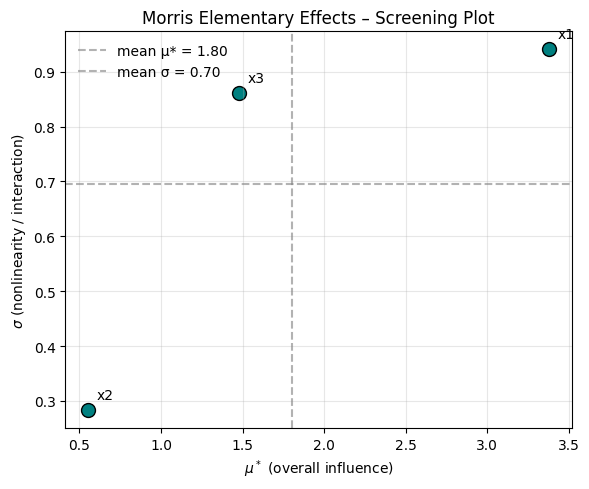

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

# --- base scatter ---
plt.scatter(summary["mu_star"], summary["sigma"],
            s=100, color="teal", edgecolor="k")

# --- reference lines (mean μ★ and mean σ) ---
mu_mean = summary["mu_star"].mean()
sigma_mean = summary["sigma"].mean()

plt.axvline(mu_mean, color="gray", linestyle="--", alpha=0.6,
            label=f"mean μ* = {mu_mean:.2f}")
plt.axhline(sigma_mean, color="gray", linestyle="--", alpha=0.6,
            label=f"mean σ = {sigma_mean:.2f}")

# --- labels for each variable ---
for var_name in summary.index:
    plt.text(summary.loc[var_name, "mu_star"] + 0.05,
             summary.loc[var_name, "sigma"] + 0.02,
             var_name, fontsize=10)

# --- axes & title ---
plt.xlabel(r"$\mu^*$ (overall influence)")
plt.ylabel(r"$\sigma$ (nonlinearity / interaction)")
plt.title("Morris Elementary Effects – Screening Plot")
plt.legend(loc="upper left", frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### interpretation:

The graph shows the following: 

- $x_2$ has low influence and low interaction
- $x_1$ has high interaction and high influence
- $x_3$ has high interaction but low influence

This makes sense looking at our model: 

$$
f(x_1, x_2, x_3) = 2x_1 + 0.5x^2_2 + 3x_1 x_3
$$

features of this function:

- $2x_1$ linear effect of $x_1$
- $0.5x^2_2$ small but nonlinear effect of $x_2$ 
- $3x_1 x_3$ interaction between $x_1$ and $x_3$


#  Applying Morris Elementary Effects to a Real Dataset: The Palmer Penguins

To make the concept of **Morris Elementary Effects** more concrete, we'll apply it to a simple, well-known dataset — the [**Palmer Penguins**](https://allisonhorst.github.io/palmerpenguins/) dataset.  
This dataset provides morphological measurements for three penguin species (*Adelie*, *Chinstrap*, and *Gentoo*) collected from islands in the Palmer Archipelago, Antarctica.

It is often used as a modern alternative to the classic *Iris* dataset because:
- It contains a small number of continuous, interpretable features.
- The relationships between variables are biologically intuitive (e.g., larger flipper length → heavier penguin).
- It contains both linear and nonlinear interactions, which make it a good demonstration dataset for **sensitivity analysis** methods like Morris.

---

##  Goal

We’ll use the **Morris method** to analyze which morphological features most influence a penguin’s **body mass**.

Specifically:
1. **Inputs (factors)**:  
   - Bill length (mm)  
   - Bill depth (mm)  
   - Flipper length (mm)  
2. **Output (model response)**:  
   - Body mass (g)

We’ll fit a simple regression model \( f(x_1, x_2, x_3) \) that predicts body mass from these inputs, then treat this model as our “black box.”  
Afterward, we’ll apply the **Morris Elementary Effects method** to quantify:
- \( \mu^* \) → the overall (average) influence of each input, and  
- \( \sigma \) → the variability or nonlinearity of that influence across the input space.

---

## Why this example works

- **Interpretability**: It’s easy to reason about which traits should matter (flipper length and bill length should correlate with mass).  
- **Dimensional simplicity**: With only 3 numeric inputs, the results are easy to visualize in 2D (μ★–σ plot).  
- **Interaction potential**: The relationships are not purely linear — for instance, the effect of flipper length might depend on species or bill size.

---

> By working with this dataset, we can see how the Morris method distinguishes between *strong, consistent* influences (high μ★, low σ) and *context-dependent, interacting* ones (high μ★, high σ), even in an everyday biological system.


In [24]:
import seaborn as sns
import pandas as pd

# Load dataset
penguins = sns.load_dataset("penguins")
penguins.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [25]:
# keep only columns we need and drop NAs

cols = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g"
]

df = penguins[cols].dropna().copy()
df.head(), df.shape


(   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
 0            39.1           18.7              181.0       3750.0
 1            39.5           17.4              186.0       3800.0
 2            40.3           18.0              195.0       3250.0
 4            36.7           19.3              193.0       3450.0
 5            39.3           20.6              190.0       3650.0,
 (342, 4))

### fit simple regression model

We'll use scikit-learns linear regression as our block-box model.

This gives us $\hat{y} = f(x_1,x_2,x_3)$ that we can later probe with Morris.



In [26]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]]
y = df["body_mass_g"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

model = LinearRegression()
model.fit(X_train, y_train)

print("R^2 on train:", model.score(X_train, y_train))
print("R^2 on test :", model.score(X_test, y_test))
model.coef_, model.intercept_


R^2 on train: 0.7694159737586672
R^2 on test : 0.7210757528501677


(array([ 7.12002238,  7.65512529, 48.21508216]),
 np.float64(-5931.683059218843))

### wrap fitted model as function

Morris neds a function that takes inputs and returns a scalar output.

We'll define a function that:

- accepts three inputs(bill_length, bill_depth, flipper_length),
- packs them into the shape scikit-learn expects
- returns the predicted body mass in grams



In [27]:
def penguin_mass_model(bill_length_mm, bill_depth_mm, flipper_length_mm):
    """
    Predict penguin body mass (g) from morphology using our trained linear model.
    Inputs are scalars.
    Returns a scalar prediction (grams).
    """
    X_input = pd.DataFrame([{
        "bill_length_mm": bill_length_mm,
        "bill_depth_mm": bill_depth_mm,
        "flipper_length_mm": flipper_length_mm
    }])
    y_pred = model.predict(X_input)
    return float(y_pred[0])

### define realistic ranges for each input

to run morris, we need to tell it what ranges each input can take.

We'll base that on the observed min/max in the data



In [28]:
feature_ranges = {
    "bill_length_mm": (
        df["bill_length_mm"].min(),
        df["bill_length_mm"].max()
    ),
    "bill_depth_mm": (
        df["bill_depth_mm"].min(),
        df["bill_depth_mm"].max()
    ),
    "flipper_length_mm": (
        df["flipper_length_mm"].min(),
        df["flipper_length_mm"].max()
    )
}

feature_ranges


{'bill_length_mm': (np.float64(32.1), np.float64(59.6)),
 'bill_depth_mm': (np.float64(13.1), np.float64(21.5)),
 'flipper_length_mm': (np.float64(172.0), np.float64(231.0))}

In [29]:
# --- 1. Define the sampling and EE computation function ---
def sample_elementary_effects_real_model(model_func, feature_ranges, n_samples=100, delta=0.05):
    """
    Compute elementary effects for each continuous input variable in the model.
    
    Parameters
    ----------
    model_func : callable
        A function that takes three inputs (bill_length, bill_depth, flipper_length)
        and returns a scalar prediction (body mass in g).
    feature_ranges : dict
        Dictionary mapping feature names to (min, max) tuples.
    n_samples : int
        Number of random points to sample.
    delta : float
        Fractional perturbation of each variable (e.g., 0.05 = 5% of its range).
    """
    features = list(feature_ranges.keys())
    records = []

    for _ in range(n_samples):
        # Randomly sample a base point inside the observed feature space
        base_point = {}
        for feat, (low, high) in feature_ranges.items():
            base_point[feat] = np.random.uniform(low=low + 0.05*(high-low), high=high - 0.05*(high-low))
        
        # Baseline prediction
        y0 = model_func(base_point[features[0]], base_point[features[1]], base_point[features[2]])

        ee_point = {}
        for feat in features:
            low, high = feature_ranges[feat]
            step = delta * (high - low)

            perturbed_point = base_point.copy()
            perturbed_point[feat] = np.clip(base_point[feat] + step, low, high)

            y1 = model_func(
                perturbed_point[features[0]],
                perturbed_point[features[1]],
                perturbed_point[features[2]]
            )

            ee_point[f"{feat}_EE"] = (y1 - y0) / step

        records.append(ee_point)

    return pd.DataFrame(records)

# --- 2. Run the sampling ---
ee_df = sample_elementary_effects_real_model(
    penguin_mass_model,
    feature_ranges,
    n_samples=100,
    delta=0.05
)

ee_df.head()

,bill_length_mm_EE,bill_depth_mm_EE,flipper_length_mm_EE
0,7.120022,7.655125,48.215082
1,7.120022,7.655125,48.215082
2,7.120022,7.655125,48.215082
3,7.120022,7.655125,48.215082
4,7.120022,7.655125,48.215082


In [30]:
summary = pd.DataFrame({
    "mu_star": [ee_df[c].abs().mean() for c in ee_df.columns],
    "sigma": [ee_df[c].std(ddof=1) for c in ee_df.columns]
}, index=[c.replace("_EE", "") for c in ee_df.columns])

summary


,mu_star,sigma
bill_length_mm,7.120022,6.091025e-13
bill_depth_mm,7.655125,2.030373e-12
flipper_length_mm,48.215082,3.332289e-13


In [31]:
print(summary)
print()

print("mu_star stats:")
print(" min:", summary["mu_star"].min())
print(" max:", summary["mu_star"].max())
print(" mean:", summary["mu_star"].mean())

print("\nsigma stats:")
print(" min:", summary["sigma"].min())
print(" max:", summary["sigma"].max())
print(" mean:", summary["sigma"].mean())

print("\nAny NaN in summary?")
print(summary.isna().any())


                     mu_star         sigma
bill_length_mm      7.120022  6.091025e-13
bill_depth_mm       7.655125  2.030373e-12
flipper_length_mm  48.215082  3.332289e-13

mu_star stats:
 min: 7.120022379018935
 max: 48.21508215626039
 mean: 20.996743274284498

sigma stats:
 min: 3.3322894109700684e-13
 max: 2.030373237990764e-12
 mean: 9.909015515269688e-13

Any NaN in summary?
mu_star    False
sigma      False
dtype: bool


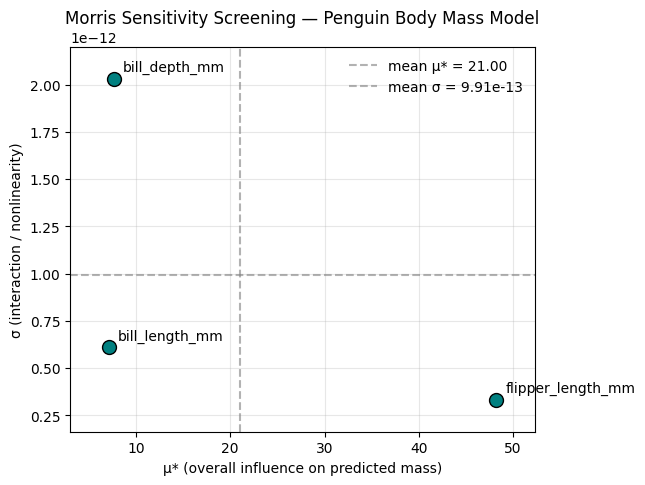

In [32]:


mu_vals = summary["mu_star"].values.astype(float)
sigma_vals = summary["sigma"].values.astype(float)
names = summary.index.tolist()

mu_mean = float(np.mean(mu_vals))
sigma_mean = float(np.mean(sigma_vals))

# define plotting limits with a small % padding around actual data
mu_min = mu_vals.min()
mu_max = mu_vals.max()
sigma_min = sigma_vals.min()
sigma_max = sigma_vals.max()

mu_pad = 0.1 * (mu_max - mu_min if mu_max > mu_min else 1.0)
sigma_pad = 0.1 * (sigma_max - sigma_min if sigma_max > sigma_min else 1.0)

x_lo = mu_min - mu_pad
x_hi = mu_max + mu_pad
y_lo = sigma_min - sigma_pad
y_hi = sigma_max + sigma_pad

fig, ax = plt.subplots(figsize=(6,5))

# scatter points
ax.scatter(mu_vals, sigma_vals,
           s=100, color="teal", edgecolor="k", zorder=3)

# adaptive label offset: 2% of axis span instead of hardcoded 0.02
x_offset = 0.02 * (x_hi - x_lo)
y_offset = 0.02 * (y_hi - y_lo)

for x, y, label in zip(mu_vals, sigma_vals, names):
    ax.text(x + x_offset, y + y_offset, label,
            fontsize=10, zorder=4)

# reference lines
ax.axvline(mu_mean, color="gray", linestyle="--", alpha=0.6,
           label=f"mean μ* = {mu_mean:.2f}")
ax.axhline(sigma_mean, color="gray", linestyle="--", alpha=0.6,
           label=f"mean σ = {sigma_mean:.2e}")

# set sane limits
ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)

ax.set_xlabel("μ* (overall influence on predicted mass)")
ax.set_ylabel("σ (interaction / nonlinearity)")
ax.set_title("Morris Sensitivity Screening — Penguin Body Mass Model")
ax.grid(alpha=0.3)
ax.legend(loc="upper right", frameon=False)

plt.show()


### Interpreting the Morris screening for penguin mass

We used a linear regression model to predict penguin body mass (g)
from bill length, bill depth, and flipper length. We then applied
the Morris Elementary Effects method to measure how sensitive the
predicted mass is to each morphological input.

Results:
- `flipper_length_mm` has the highest μ*, meaning it is the most
  influential predictor of body mass overall. Small changes in
  flipper length lead to large changes in predicted body mass.
- `bill_length_mm` and `bill_depth_mm` also affect predicted mass,
  but less strongly (their μ* values are much smaller than flipper
  length).
- All three inputs have σ values that are ~0. This means the effect
  of each input is essentially constant across the range of values
  we sampled. In other words, the model's response to each input is
  linear and does not depend much on the other inputs.

This is exactly what we'd expect from a plain linear regression with
no interaction terms: each predictor contributes additively and with
a roughly constant slope. Because σ is near zero, we see no evidence
of strong interactions or nonlinear behavior in this model.

In a more complex ecological model (or in a spatial MCDA with
nonlinear suitability thresholds), we would expect to see higher σ,
which would indicate that certain inputs matter only under certain
conditions or in combination with other inputs.


##  Spatial Sensitivity Analysis with Synthetic Rasters

Now that we understand how Morris’ *elementary effects* method works conceptually, let’s explore how it applies in a **spatial MCDA (Multi-Criteria Decision Analysis)** setting — the kind used in suitability or recharge mapping.

In a spatial context, our “model” is often a **weighted linear combination (WLC)** of several raster criteria:

* slope
* soil permeability
* rainfall
* land cover, etc.

Each criterion is spatially continuous, and we assign **weights** to express their relative importance.
The Morris method lets us vary these weights systematically to see:

* which weights most strongly influence the overall suitability outcome (μ★), and
* which weights interact in nonlinear ways (σ > 0).

To demonstrate this, we’ll create a **synthetic dataset of rasters** that mimics realistic environmental layers and intentionally includes **nonlinearity and interactions**.

Our synthetic study area will include:

* `slope` — higher toward one corner (representing uplands),
* `permeability` — highest in a central “valley,”
* `rainfall` — decreasing west to east, with sinusoidal north–south variability.

We’ll then define four “factors” that influence a hypothetical **recharge suitability score**:

| Symbol   | Description                    | Behavior                                           |
| :------- | :----------------------------- | :------------------------------------------------- |
| *wₛₗₒₚₑ* | Weight on slope suitability    | favors gentle slopes (nonlinear decay)             |
| *wₚₑᵣₘ*  | Weight on soil permeability    | roughly linear (more permeable → better)           |
| *wᵣₐᵢₙ*  | Weight on rainfall suitability | “Goldilocks” response — midrange rainfall best     |
| *wᵢₙₜ*   | Weight on interaction term     | captures synergy between rainfall and permeability |

We’ll define a composite suitability model:

$$
\text{Suitability}(i,j) =
w_\text{slope},f_\text{slope}(s_{ij}) +
w_\text{perm},f_\text{perm}(p_{ij}) +
w_\text{rain},f_\text{rain}(r_{ij}) +
w_\text{int},f_\text{int}(p_{ij}, r_{ij})
$$

Then we’ll summarize each run by a single management-style indicator:

> **% of the landscape with suitability ≥ 0.7**

Finally, we’ll apply the **Morris elementary-effects** method to the weights
$((w_\text{slope}, w_\text{perm}, w_\text{rain}, w_\text{int}))$
to estimate μ★ and σ — showing which weights matter most and which behave nonlinearly or interactively.

---

### Step 1. Generate synthetic rasters with spatial structure

What we will do:

slope: increases toward one corner (like uplands vs basin floor).

perm: hotspot of high permeability (like an alluvial fan or paleo-channel).

rain: west-to-east gradient plus a sinusoidal north-south climate band.


In [34]:

np.random.seed(42)

# grid size
nx, ny = 50, 50

# create coordinate grids (to allow gradients across space)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y, indexing="ij")  # X[i,j], Y[i,j] in [0,1]

# synthetic "slope": higher slope in the NE corner + noise
slope = 30 * (0.3*X + 0.7*Y) + np.random.normal(0, 2, (nx, ny))
slope = np.clip(slope, 0, 30)  # degrees

# synthetic "soil permeability" (perm): better in valley-like band
perm = 0.6 + 0.4*np.exp(-((X-0.5)**2 + (Y-0.2)**2)/0.05)
perm += np.random.normal(0, 0.05, (nx, ny))
perm = np.clip(perm, 0, 1)

# synthetic "rainfall": gradient + hump
rain = 200 + 600*(1 - X) + 80*np.sin(3*np.pi*Y)
rain += np.random.normal(0, 20, (nx, ny))
rain = np.clip(rain, 200, 800)  # mm/yr

slope.shape, perm.shape, rain.shape


((50, 50), (50, 50), (50, 50))

### Step 2. define the transformed suitability sub-scores 

Now we define the $f_{slope}, f_{perm}, f_{rain}$, and the interaction term.

Design choices:

- We want nonlinearity: e.g. very steep slopes get penalized sharply.
- We want "Goldilocks" rainfall: mid-range rain gives best recharge; too little = no water, too much = maybe runoff.
- We want interaction between perm and rain: rain only helps if perm is high.

In [35]:
def score_slope(slope_grid):
    # high score for gentle slopes, decays nonlinearly
    # slope in degrees 0..30
    # we'll do an exponential decay so it's strongly nonlinear
    return np.exp(-slope_grid / 10.0)  # near 1 at 0 deg, ~exp(-3)=0.05 at 30 deg

def score_perm(perm_grid):
    # more permeable is better, roughly linear
    # perm already in [0,1]
    return perm_grid  # identity for now

def score_rain(rain_grid):
    # peak around moderate rainfall (e.g. 500 mm),
    # penalize too dry or too wet via a Gaussian-like curve
    return np.exp(-((rain_grid - 500.0)**2) / (2*(100.0**2)))
    # ~1.0 at 500 mm, drops off as you move away

def score_interaction(perm_grid, rain_grid):
    # interaction: rain only "counts" if perm is high
    # e.g. multiply them, so high perm + decent rain is very good
    # but high rain with low perm won't help
    rain_norm = (rain_grid - 200.0) / (800.0 - 200.0)  # scale rain to [0,1]
    rain_norm = np.clip(rain_norm, 0, 1)
    return perm_grid * rain_norm


### Step 3. Define the suitability model with weights

we will treat the weights as the "inputs" then we will perturb them with Morris, these are like decision-maker priorities in a WLC



In [36]:
def suitability_from_weights(w_slope, w_perm, w_rain, w_int):
    """
    Given a set of weights, compute a final suitability raster,
    then return a management-style scalar metric:
    % of the landscape above a suitability threshold.
    """
    S_slope = score_slope(slope)
    S_perm  = score_perm(perm)
    S_rain  = score_rain(rain)
    S_int   = score_interaction(perm, rain)

    # weighted linear combo including interaction layer
    suitability = (
        w_slope * S_slope +
        w_perm  * S_perm  +
        w_rain  * S_rain  +
        w_int   * S_int
    )

    # normalize by sum of weights so scores stay in a comparable range
    w_sum = (w_slope + w_perm + w_rain + w_int) + 1e-12
    suitability = suitability / w_sum

    # management-style scalar output:
    # fraction of cells with suitability >= 0.7
    high_priority = (suitability >= 0.7).mean()  # this is a single number between 0 and 1

    return float(high_priority)


### Step 4. Run Morris-style elementary effects on the weights

This is almost identical to what we did with penguins, but now:

- We’re sampling weights instead of morphology.
- We’re perturbing one weight at a time.
- We'll say each weight varies in [0.1, 1.0] — like minimum importance to strong importance — and we’ll use a fractional step.

In [37]:
weight_ranges = {
    "w_slope": (0.1, 1.0),
    "w_perm":  (0.1, 1.0),
    "w_rain":  (0.1, 1.0),
    "w_int":   (0.1, 1.0),
}

def sample_elementary_effects_wlc(model_func, weight_ranges, n_samples=100, delta=0.1):
    """
    model_func: suitability_from_weights
    weight_ranges: dict of {weight_name: (min,max)}
    n_samples: number of random base weight sets to test
    delta: step as a fraction of that weight's range
    """
    wnames = list(weight_ranges.keys())
    records = []

    for _ in range(n_samples):
        # pick a random baseline weight set, not at the extreme edges
        base_w = {}
        for wname, (lo, hi) in weight_ranges.items():
            base_w[wname] = np.random.uniform(
                lo + 0.1*(hi-lo),
                hi - 0.1*(hi-lo)
            )

        # baseline model output
        y0 = model_func(
            base_w["w_slope"],
            base_w["w_perm"],
            base_w["w_rain"],
            base_w["w_int"]
        )

        ee_point = {}
        # perturb each weight in turn
        for wname, (lo, hi) in weight_ranges.items():
            step = delta * (hi - lo)

            perturbed_w = base_w.copy()
            perturbed_w[wname] = np.clip(base_w[wname] + step, lo, hi)

            y1 = model_func(
                perturbed_w["w_slope"],
                perturbed_w["w_perm"],
                perturbed_w["w_rain"],
                perturbed_w["w_int"]
            )

            # elementary effect for this weight
            denom = step if step > 1e-12 else 1e-12
            ee_point[f"{wname}_EE"] = (y1 - y0) / denom

        records.append(ee_point)

    return pd.DataFrame(records)

ee_wlc_df = sample_elementary_effects_wlc(
    suitability_from_weights,
    weight_ranges,
    n_samples=100,
    delta=0.1
)

ee_wlc_df.head()


,w_slope_EE,w_perm_EE,w_rain_EE,w_int_EE
0,0.008889,0.013333,0.013333,-0.017778
1,-0.106667,0.066667,0.044444,-0.053333
2,-0.137778,0.075556,0.080000,-0.111111
3,0.000000,0.044444,0.008889,-0.008889
4,-0.004444,0.026667,0.031111,-0.022222


> Now we have:
>
> - Each row = one baseline weighting scenario.
> - Each column = how sensitive the “% high-priority land” is to each weight at that baseline.
> - This is a spatial decision model, with real interactions baked in (w_int affects that interaction layer we defined).

### Step 5. Summarize $\mu^*$ and $\sigma$ for the weights

In [38]:
summary_wlc = pd.DataFrame({
    "mu_star": [ee_wlc_df[c].abs().mean() for c in ee_wlc_df.columns],
    "sigma":   [ee_wlc_df[c].std(ddof=1)  for c in ee_wlc_df.columns],
}, index=[c.replace("_EE", "") for c in ee_wlc_df.columns])

summary_wlc


,mu_star,sigma
w_slope,0.059733,0.048370
w_perm,0.053911,0.026679
w_rain,0.047244,0.035660
w_int,0.053956,0.034369


#### Practice questions

1. Which weight most strongly controls ($\mu^*$) how much of the map is deemed suitable or good (gte 7)?

> *answer: w_slope has the highest $\mu^*$ or overall effect.*

2. Which weight's effect is stable vs. only matters in some regimes?

> *answer:The weight whose effect is most stable (low variability) is **w_perm**, since it has the smallest $\sigma$ value (0.0267). This means its influence on suitability is consistent across different weighting combinations, while **w_slope** shows more variability and context dependence.*

3. Does the interaction weight (w_int) have a high $\sigma$? 
*(it should because we designed it to matter more when both permeability and rain are favorable)*

>*answer:The interaction weight **w_int** does **not** have the highest $\sigma$ in this run (its value, 0.0344, is moderate), but it still shows some variability. This suggests it behaves somewhat nonlinearly — its effect depends on permeability and rainfall conditions — though not as strongly as expected in this specific simulation.*





### Step 6. plot $\mu^*$ vs $\sigma$ for the spatial model



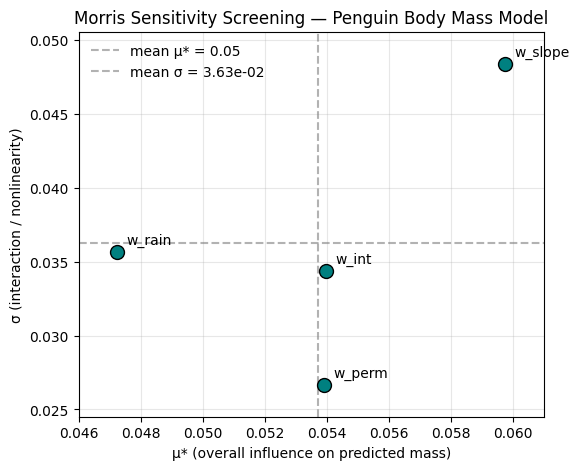

In [40]:
mu_vals = summary_wlc["mu_star"].values.astype(float)
sigma_vals = summary_wlc["sigma"].values.astype(float)
names = summary_wlc.index.tolist()

mu_mean = float(np.mean(mu_vals))
sigma_mean = float(np.mean(sigma_vals))

# define plotting limits with a small % padding around actual data
mu_min = mu_vals.min()
mu_max = mu_vals.max()
sigma_min = sigma_vals.min()
sigma_max = sigma_vals.max()

mu_pad = 0.1 * (mu_max - mu_min if mu_max > mu_min else 1.0)
sigma_pad = 0.1 * (sigma_max - sigma_min if sigma_max > sigma_min else 1.0)

x_lo = mu_min - mu_pad
x_hi = mu_max + mu_pad
y_lo = sigma_min - sigma_pad
y_hi = sigma_max + sigma_pad

fig, ax = plt.subplots(figsize=(6,5))

# scatter points
ax.scatter(mu_vals, sigma_vals,
           s=100, color="teal", edgecolor="k", zorder=3)

# adaptive label offset: 2% of axis span instead of hardcoded 0.02
x_offset = 0.02 * (x_hi - x_lo)
y_offset = 0.02 * (y_hi - y_lo)

for x, y, label in zip(mu_vals, sigma_vals, names):
    ax.text(x + x_offset, y + y_offset, label,
            fontsize=10, zorder=4)

# reference lines
ax.axvline(mu_mean, color="gray", linestyle="--", alpha=0.6,
           label=f"mean μ* = {mu_mean:.2f}")
ax.axhline(sigma_mean, color="gray", linestyle="--", alpha=0.6,
           label=f"mean σ = {sigma_mean:.2e}")

# set sane limits
ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)

ax.set_xlabel("μ* (overall influence on predicted mass)")
ax.set_ylabel("σ (interaction / nonlinearity)")
ax.set_title("Morris Sensitivity Screening — Penguin Body Mass Model")
ax.grid(alpha=0.3)
ax.legend(loc="upper left", frameon=False)

plt.show()


#### Interpretation

The plot above shows the Morris μ★–σ diagram for our synthetic spatial suitability model.
Each point represents one of the four input weights varied in the analysis:

- $\mu^*$ (x-axis) — measures the overall influence of that weight on the model output (mean absolute elementary effect).
A larger $\mu^*$  means that changing this weight tends to change the suitability outcome more strongly — i.e., it is a more influential parameter overall.

- $\sigma$ (y-axis) — measures the variability of those effects across the parameter space.
A higher $\sigma$ indicates nonlinear behavior or interactions with other parameters.
In other words, the effect of that weight depends on the values of other weights or on specific regions of the input space.

##### What the plot shows:

$w_{slope}$ shows the highest $\mu^*$  — meaning that the slope criterion is the dominant control on how much land is classified as suitable.
This makes intuitive sense: slope strongly affects recharge potential, and our transformation for slope was nonlinear, creating steep contrasts between gentle and steep terrain.

$w_{perm}$ and $w_{rain}$ have moderate $\mu^*$  values — they influence suitability, but to a smaller degree.
Their relatively low $\sigma$  values suggest that their effects are more linear and consistent across different weight combinations.

$w_{int}$ (the interaction weight) has a slightly lower $\mu^*$  than $w_{slope}$ but a comparable or higher $\sigma$ — meaning it contributes less to the total suitability on average but behaves nonlinearly.
This reflects the fact that its impact depends on the combination of permeability and rainfall, not on either one alone.

**therefore:**
- The slope weight is the most critical lever — changing it will have the greatest and most consistent effect on the area classified as “high-suitability.”

- The interaction term is important to monitor — it introduces context-dependent variability and captures coupled effects of rainfall and permeability.

- The other weights behave more linearly, meaning that their influence can be anticipated more easily and modeled with less uncertainty.

**This is a hallmark Morris result:**

- Parameters with high $\mu^*$ and low $\sigma$  → strong, predictable influence.
- Parameters with moderate $\mu^*$ but high $\sigma$  → interactive or nonlinear influence.
- Parameters with low $\mu^*$ and low $\sigma$  → negligible or near-linear effect.

## Review Questions

### Conceptual

1. What is the main purpose of the Morris elementary effects method in sensitivity analysis?

2. How does Morris differ from a simple one-at-a-time (OAT) sensitivity analysis?

3. In the Morris method, what does the elementary effect represent for a given input parameter?

4. Why do we calculate both $\mu^*$ (mu-star) and $\sigma$ (sigma), and what does each measure tell us?

5. What does a high $\mu^*$ combined with a low $\sigma$ imply about a model parameter?

6. What does a high $\sigma$ (standard deviation of elementary effects) indicate about a parameter’s behavior?

7. How do nonlinearities or interactions among variables influence $\sigma$ in Morris results?

8. Why is Morris sometimes called a “screening” method rather than a “full” global sensitivity method?

9. What is the role of $\Delta$ (delta) in the Morris method, and how is it typically chosen?

10. In a spatial MCDA context, what might a model input represent, and what would the model output represent in a Morris analysis?

### Interpretation

11. On a $\mu^*$–$\sigma$ plot, where would you expect to find a highly linear and dominant variable?

12. What does it mean if a point is high on the σ axis but low on μ★?

13. In the penguin example, why did σ values collapse toward zero?

14. In the synthetic raster model, why does the interaction term (w_int) often have a high $\sigma$?

15. How might a decision-maker interpret high $\sigma$ in a spatial suitability model?

### Answers

> *1. The main purpose of the Morris elementary effects method is to identify which input variables have the greatest overall influence on a model’s output, and to detect whether their effects are linear, nonlinear, or involve interactions with other inputs.*

> *2. Unlike a simple one-at-a-time (OAT) analysis that tests variables around a single baseline, Morris repeats OAT experiments across many random starting points in the input space, allowing it to capture global (not just local) sensitivity patterns.*

> *3. The elementary effect for a given parameter represents the change in model output resulting from a small perturbation of that parameter, divided by the size of the change ($\Delta$). It approximates the local slope of the model’s response surface.*

> *4. $\mu^*$ measures the average magnitude of influence of an input (its overall importance), while σ measures how variable that influence is across the input space (nonlinearity or interaction effects).*

> *5. A high $\mu^*$ and low $\sigma$ indicate a parameter that has a strong, consistent, and largely linear effect on the model output.*

> *6. A high $\sigma$ means the parameter’s influence changes across the input space — suggesting nonlinear behavior or interactions with other parameters.*

> *7. Nonlinearities or interactions cause $\sigma$ to increase because the sign or magnitude of the elementary effects vary depending on where in the parameter space the sample is taken.*

> *8. Morris is called a “screening” method because it efficiently identifies which parameters are important without requiring full global variance decomposition (like Sobol or FAST). It’s often used as a first step before more detailed analyses.*

> *9. $\Delta$ (delta) defines the size of the perturbation for each elementary effect. It is typically a small fraction (e.g., 0.1–0.2) of the parameter’s total range to ensure that local changes approximate the model’s gradient while still exploring meaningful variability.*

> *10. In a spatial MCDA, model inputs might represent layer weights (e.g., slope, permeability, rainfall importance), while the output could represent an aggregated measure such as overall suitability, recharge potential, or % of land above a suitability threshold.*

---

> *11. A highly linear and dominant variable appears toward the lower right of the $\mu^*$–$\sigma$ plot — high $\mu^*$(strong influence) and low $\sigma$ (consistent, linear behavior).*

> *12. A point high on the $\sigma$ axis but low on $\mu^*$ represents a parameter with weak average influence but strong nonlinear or context-dependent effects.*

> *13. In the penguin example, $\sigma$ values collapsed toward zero because the regression model was purely linear and additive, so each variable’s effect was constant and did not vary with the others.*

> *14. In the synthetic raster model, the interaction weight (w_int) often has a high σ because its influence depends jointly on permeability and rainfall — the effect is strong only where both variables are favorable.*

> *15. A decision-maker might interpret high $\sigma$ as an indicator of uncertainty or context dependency — meaning that the importance of that criterion changes across the landscape or depends on how other factors are weighted.*
